We require the following input data: the amount of SO₂ in teragrams (Tg), the altitude and depth in kilometers, latitude and longitude in degrees, and the date and time of the eruption (year, month, day, hour, and minute). If no information is provided about the emission duration, it is assumed to occur over a 6-hour period from 12:00 to 18:00 UT. The injection depth represents 1-sigma width of the Gaussian profile, centered on the emission height provided, or the vertical extent of the injection for an Uniform injection.

The section of the code that requires modification is the **Definition Phase** , where the paths for input and output files, output resolution, mass scaling factor, and the years to be included in the climatology are specified.

Spectral functions come from https://github.com/blychs/scripts_musica.git.

# Modules, functions and constants

In [5]:
import sys
sys.path.append('/glade/u/home/iquaglia/scripts_musica/')

In [6]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import datetime as dt
from dateutil import rrule
from netCDF4 import Dataset 
import pandas as pd

from scipy.stats import norm
from scipy.integrate import quad

# Pablo's functions
import nearest_neighbour

In [7]:
# Constants
Ra = 6.37122e8         # Earth radius in cm (CAM)

# Create emissions file

## Definition phase : make changes only here

In [8]:
# ------------ Define input and output paths ------------
# Path and name of SO2 dataset
#in_path = "/glade/work/iquaglia/input_file/"
#infile = "utsvolcemis_input4MIPs_emissions_CMIP_UOEXETER-CMIP-2-2-1_gn_17500101-20231120"
in_path = "/glade/campaign/cesm/cesmdata/input4MIPs_raw/input4MIPs/CMIP7/CMIP/uoexeter/UOEXETER-CMIP-2-2-1/atmos/day/utsvolcemis/gn/v20250521/"
infile = "utsvolcemis_input4MIPs_emissions_CMIP_UOEXETER-CMIP-2-2-1_gn_17500101-20231120"

out_path = "/glade/work/iquaglia/input_file/new_files/"
outfile = "utsvolcemis_CMIP-2-2-1_gn_17500101-20231120"

# ----------------- Define resolutions ------------------
## Horizontal
res = "1deg"      # 0.95x1.25
# res = "2deg"    # 1.9x2.5
# res = "ne30"    # spectral element, 30 means 1 deg

## Vertical
hres =  0.5 # km
vtop = 40 # km

# ---------- Define vertical injection profile ----------
# inj_distr = 'unifm'
inj_distr = 'gauss'


# -- Define thresholds for amounts of So2 and altitude --
# Mass scaling factor based on the amount of SO2 injected
doMassScaling = True
massSO2thresh =  10       # threshold (Tg) for eruptions scaled by MassFactor
MassFactor_max = 1/1.8    # scaling factor for eruptions above the threshold
MassFactor_min = 1/1.8    # scaling factor for eruptions below the threshold
mass_scal = ''
if doMassScaling:
    mass_scal = '_mass-scaling'


# Altitude scaling factor applied to eruption occurring above 20 km and Tg of So2 above altSO2thresh
doAltReduction = True
alt_reduct = ''
altSO2thresh = 3.5       # threshold (Tg) for altitude reduction to 18-20 km
if doAltReduction:
    alt_reduct = '_alt-reduction'

# -- Climatology --------------------------------------------
# Years for climatology
year_in = 1850
year_fn = 2021

## Load injection file

In [9]:
volcs = xr.open_dataset(in_path + infile + '.nc')

index_volc = volcs.eruption_number
n_erups = len(volcs.eruption_number)

TgSO2 = volcs.utsvolcemis*1e-9 # Tg of SO2

z = volcs.height/1000  # km
dz = volcs.depth/1000  # km
lat = volcs.lat.rename('vlat')
lon = volcs.lon.rename('vlon')
lon = lon.where( lon >= 0, lon + 360) # Shift longitude from -180,180 to 0,360

time = volcs.time

year = volcs.time.dt.year
month = volcs.time.dt.month
day = volcs.time.dt.day
hour = volcs.time.dt.hour
minute = volcs.time.dt.minute

# 6-hour emissions from 12:00 to 18:00 UT # We decided it as it is not defined in the input file
hour = np.ones(len(volcs.eruption_number), ) * 12
minute = np.ones(len(volcs.eruption_number), ) * 0
duration = np.ones(len(volcs.eruption_number), ) * 6 # default 6-hour eruptions

## Plots: Visualization of the input file

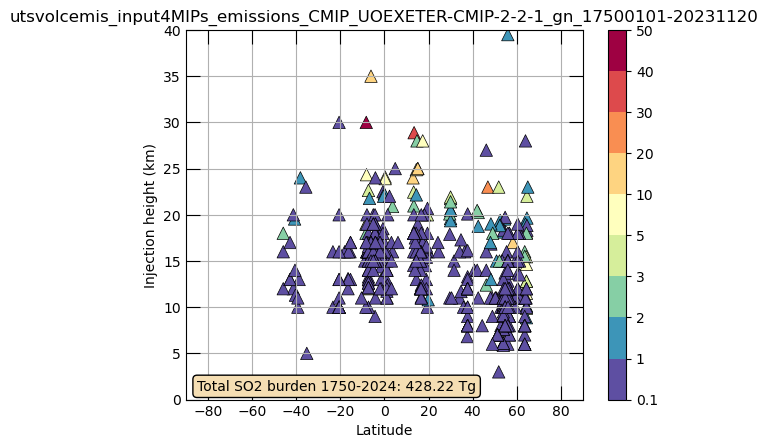

In [12]:
fig, ax = plt.subplots() 

ax.set_title(infile)

cmap = plt.cm.Spectral_r
cnorm = mpl.colors.BoundaryNorm([0.1, 1, 2, 3, 5, 10, 20, 30, 40, 50 ], cmap.N)

c = ax.scatter(lat, z, c=TgSO2, edgecolors='k', linewidths=0.5,  marker='^', s=80, cmap=cmap, norm=cnorm)
cbar = plt.colorbar(c, ticks=[0.1, 1, 2, 3, 5, 10, 20, 30, 40, 50 ])
cbar.ax.set_yticklabels(     [0.1, 1, 2, 3, 5, 10, 20, 30, 40, 50 ] )
ax.text(-85, 1, 'Total SO2 burden 1750-2024: ' + str('%.2f' %  TgSO2.sum().values) + ' Tg', 
        fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=1))

# Axis Aspect
ax.set_xlabel('Latitude')
ax.set_ylabel('Injection height (km)')
ax.set_xlim([-90, 90])
ax.set_ylim([0, 40])
ax.grid()
ax.tick_params(direction="in", length=10, top=True, right=True)
ax.tick_params(which='minor', direction="in", length=5, top=True, right=True)


fig.patch.set_facecolor('white')

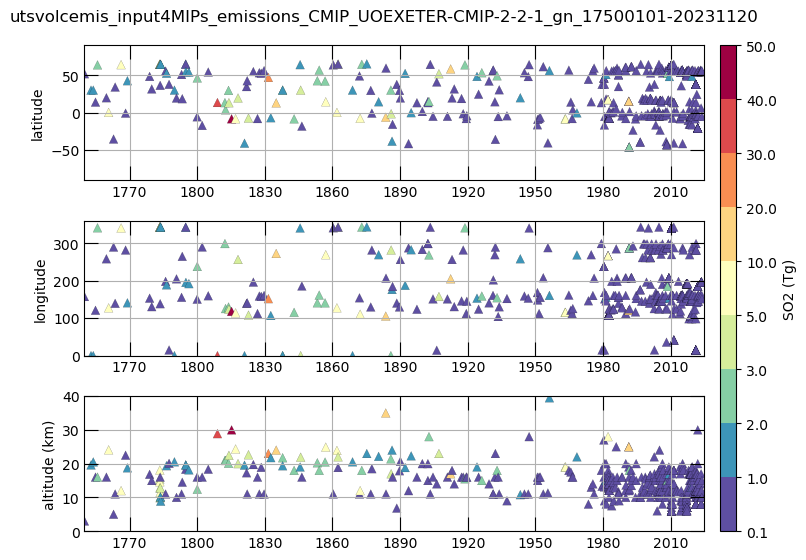

In [13]:
fig, axs = plt.subplots(figsize=(8, 6), nrows=3, ncols=1) 
axs = axs.flatten()

fig.subplots_adjust(top=0.92, hspace=0.3)

fig.suptitle(infile)

cmap = plt.cm.Spectral_r
cnorm = mpl.colors.BoundaryNorm([0.1, 1, 2, 3, 5, 10, 20, 30, 40, 50 ], cmap.N)


axs[0].scatter(volcs.time.values, lat, c=TgSO2, edgecolors='k', linewidths=0.1, marker='^', s=40, cmap=cmap, norm=cnorm)
axs[0].set_ylabel('latitude')
axs[0].set_ylim([-90, 90])

axs[1].scatter(volcs.time.values, lon, c=TgSO2, edgecolors='k', linewidths=0.1, marker='^', s=40, cmap=cmap, norm=cnorm)
axs[1].set_ylabel('longitude')
axs[1].set_ylim([0, 360])

cs = axs[2].scatter(volcs.time.values, z, c=TgSO2, edgecolors='k', linewidths=0.1, marker='^', s=40, cmap=cmap, norm=cnorm)
axs[2].set_ylabel('altitude (km)')
axs[2].set_ylim([0, 40])


# Axis Aspect
cbar_ax = fig.add_axes([axs[2].get_position().x0 + axs[2].get_position().width + 0.02,  axs[2].get_position().y0,
                      0.02, axs[0].get_position().y0 + axs[0].get_position().height - axs[2].get_position().y0])
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', ticks=[0.1, 1, 2, 3, 5, 10, 20, 30, 40, 50 ])
cbar.set_label('SO2 (Tg)', fontsize=10)  
cbar.ax.tick_params(labelsize=10)

for i, ix  in enumerate(axs):
    axs[i].tick_params(direction="in", length=10, top=True, right=True)
    axs[i].tick_params(which='minor', direction="in", length=5, top=True, right=True)
    axs[i].set( xlim=[dt.date(1750, 1, 1), dt.date(2024, 12, 31)]) 
    axs[i].xaxis.set_major_locator(mdates.YearLocator(30, month=1, day=1))
    #axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    #axs[e].minorticks_on()
    axs[i].grid()

fig.patch.set_facecolor('white')

## Load Grid

In [14]:
# Reading grid file based on resolution
if (res == "2deg"): 
    templateFilename = "/glade/work/iquaglia/input_file/grids/coords_1.9x2.5_L70_c241029.nc"
elif (res == "1deg"): 
    templateFilename = "/glade/work/iquaglia/input_file/grids/coords_0.95x1.25_L93_c250114.nc"
elif (res == "ne30"): 
    templateFilename = "/glade/campaign/acom/MUSICA/grids/ne30pg3/ne30pg3.nc"

# Open grid file
grid = xr.open_dataset(templateFilename)

# Create altitude 
galt = xr.DataArray(data=np.arange(hres, vtop + hres , hres),  dims=["altitude"], coords={'altitude':np.arange(hres, vtop + hres , hres)})
galt_int = xr.DataArray(data=np.arange(hres/2, vtop + hres/2 + hres , hres),  dims=["altitude"], coords={'altitude':np.arange(hres/2, vtop + hres/2 + hres , hres)})

if res in ["1deg", "2deg"]:
    glat = grid.lat
    glon = grid.lon
    gw = grid.gw                                            # np.cos(theta) * (dtheta), gw.sum() = 2
    dphi = (glon[1].values - glon[0].values) * np.pi/180
    grid_area_rd = gw.expand_dims(lon=glon, axis=1) * dphi          # grid cell area in radiants^2


elif res == "ne30" :
    grid = grid.rename({'grid_center_lat':'lat', 'grid_center_lon':'lon', 'grid_size':'ncol'})
    glat = grid.lat
    glon = grid.lon
    ncol = grid.ncol
    grid_area_rd = grid.grid_area                                # grid cell area in radiants^2


grid_area_cm = grid_area_rd * Ra**2                         # Earth surface area in cm^2

print('Earth surface area in cm2: ', grid_area_cm.sum().values, '4 * Pi: ', grid_area_rd.sum().values)

Earth surface area in cm2:  5.100996990707616e+18 4 * Pi:  12.566370614359174


## Create timeseries of SO2 injection profiles

In [ ]:
if res in ["1deg", "2deg"]:
    nTimes = len(index_volc) * 4 + 2
    
    dates = np.zeros(nTimes)
    dates_sec = np.zeros(nTimes)
    
    dates[0]=10101 # yyyymmdd
    dates_sec[0] = 1800
    
    # Emission inizialization
    stratvolc =  xr.DataArray( np.zeros((nTimes, len(galt), len(glat), len(glon))), 
                    name='stratvolc',  dims=["time", "altitude", "lat", "lon"],
                    coords={'time':dates, 'altitude':galt.altitude, 'lat':glat, 'lon':glon}, 
                    attrs=dict( long_name="SO2 elevated emissions from explosive volcanoes", units='molecules/cm3/s'))
    
    print('Resolution:', res, 'Do mass scaling?', doMassScaling)
    t = 0
    for i, iv in enumerate(index_volc): 
        ix = i
        # Same day and location 
        if (time[ix] == time[ix-1]) & (lat[ix] == lat[ix-1]) & (lon[ix] == lon[ix-1]) & (z[ix] == z[ix-1]):
            print('duplicate', ix,' time: ', time[ix].values)
            # continue
            t = t - 1
            
        # Merge eruptions occuring on the same day 
        if (time[ix] == time[ix-1]) & ((lat[ix] != lat[ix-1]) or (lon[ix] != lon[ix-1]) or (z[ix] != z[ix-1])):
            print('same day injections', ix, ' time: ', time[ix].values, ' lat: ', lat[ix].values, ' lon: ', lon[ix].values, ' alt: ', z[ix].values,
                 ' lat: ', lat[ix-1].values, ' lon: ', lon[ix-1].values, ' alt: ', z[ix-1].values) 
            t = t - 1
    
        # Mass scaling
        if (doMassScaling):
            if (TgSO2[ix].values >=  massSO2thresh):
                so2 = TgSO2[ix] * MassFactor_max
            else:
                so2 = TgSO2[ix] * MassFactor_min
            print('Mass scaling', ix, ' time: ', time[ix].values,'Initial Tg: ', TgSO2[ix].values, 'Scaled Tg: ', so2.values)

        else:
            so2 = TgSO2[ix]
           
        # Altitude scaling for injection above 20 km and Tg of So2 above altSO2thresh
        if (TgSO2[ix].values >=  altSO2thresh) & (z[ix].values > 20) & (doAltReduction):
            print('Altitude adjustment', i, ' time: ', time[ix].values, 'z: ', z[ix].values,'z_adjusted: 20')
            z[ix] = 20
            
        # Check if the are negative injection
        if TgSO2[ix].values<=0:
            print(i, ix, 'SO2 injected is zero')
            break
            
        # For each eruption we have to define 4 timesteps: the 2 timesteps between which the injection occurs, 1 timestep before and after with no injections
        t1=t*4+1
        t2=t*4+2
        t3=t*4+3
        t4=t*4+4
        dates[t1:t4+1] = 10000 * year[ix] + 100 * month[ix] + day[ix]
        
        StartDateSec = int(hour[ix] * 3600 + minute[ix]*60)     # time of day the day when the eruption occurs (unit: seconds)
        EndDateSec = StartDateSec + duration[ix] * 3600         # time of day the day when the eruption is over (unit: seconds)
        
        dates_sec[t1:t4+1]= np.array([StartDateSec-1, StartDateSec, EndDateSec-1, EndDateSec]) 
        
        molecSO2 = so2 * 1e12 / 64. * 6.022 * 1e23              # total molecules of SO2
        
        
        # Redifine lat and lon e zlev limits accordingly with the grid
        lat[ix] = grid.lat.sel(lat=lat[ix], method='nearest')
        lon[ix] = grid.lon.sel(lon=lon[ix], method='nearest')
        # ilon = list(grid.lon.values).index(grid.sel(lon=vlon[i].values, method='nearest').lon)
        # ilat = list(grid.lat.values).index(grid.sel(lat=vlat[i].values, method='nearest').lat)
    
        # Create injection rate
        volc_grid_area_cm = grid_area_cm.where(( glat == lat[i]) & (glon == lon[i]) , 0)  # (lat, lon) grid cell area in cm2
        volc_grid_norm = volc_grid_area_cm/volc_grid_area_cm.sum()      # (lat, lon) grid of weights
        Sv = volc_grid_area_cm.sum()                                    # area of volcanic surface
        
        if inj_distr == 'unifm':
            z2 = np.min( [ z[ix] + dz[ix], galt_int[-1]] )
            z1 = np.max( [ z[ix] - dz[ix], galt_int[0]])
    
            depth = (z2 - z1)*1e5                             # emission depth in cm
            volume = Sv * depth                               # cm3
            rate =  molecSO2 / volume / (duration[ix] * 3600) # molec/cm3/s over ix hours
       
            for k, alt in enumerate(galt):
                if ((z1 <= galt_int[k+1]) & (z2 >= galt_int[k])): # Check that the altitude band is included in the vert dist
                    top = np.min( [z2, galt_int[k+1]] )
                    bot = np.max( [z1, galt_int[k]])
                    factor = (top-bot)/(galt_int[k+1]-galt_int[k])
                    stratvolc[t2, k, :, :] = stratvolc[t2, k, :, :]  + (volc_grid_norm*rate*factor) 
                    stratvolc[t3, k, :, :] = stratvolc[t3, k, :, :]  + (volc_grid_norm*rate*factor)            
        
        elif inj_distr == 'gauss':
            mu = galt.sel(altitude=z[i], method='nearest')        # zlev and center of Gaussian distribution
            min_3std = galt.sel(altitude=mu-3*dz[ix], method='nearest')
            max_3std = galt.sel(altitude=mu+3*dz[ix], method='nearest')
    
            if min_3std < galt[0]:
                min_3std = galt[0]
        
            if max_3std > galt[-1]:
                max_3std = galt[-1]
        
            imin = list(galt).index(galt.sel(altitude=min_3std))
            imax = list(galt).index(galt.sel(altitude=max_3std))
                
            z_3s = np.arange(min_3std, max_3std + 0.01, hres) # 0.01 is just a value to include max_3std as right extreme
            pdf = norm.pdf(z_3s, mu, dz[ix])        
            pdf = pdf / (pdf).sum()                      # area of PDF between two extremes of injection       
            depth = hres*1e5                             # pdf is in 1/km therefore depth is only the conversion factor to cm
            # depth = 1e5 
            
            volume = Sv * depth                               # cm3
            rate =  molecSO2 / volume / (duration[ix] * 3600) # molec/(cm3)/s over ix hours
            
            # stratvolc is zero if there haven't been any other eruptions at the same time
            if min_3std == max_3std:
                print("Dz=0", i, ' time: ', time[ix].values)
    
                stratvolc[t2, imin, :, :] = stratvolc[t2, imin, :, :] + (volc_grid_norm*rate).values
                stratvolc[t3, imin, :, :] = stratvolc[t3, imin, :, :] + (volc_grid_norm*rate).values
    
            else:
                stratvolc[t2, imin:imax+1, :, :] = stratvolc[t2, imin:imax+1, :, :] + pdf[:, None, None]*(volc_grid_norm*rate).values[None,:,:]
                stratvolc[t3, imin:imax+1, :, :] = stratvolc[t3, imin:imax+1, :, :] + pdf[:, None, None]*(volc_grid_norm*rate).values[None,:,:]
        
        t = t + 1
    
    dlast = t4 + 1
    dates[dlast] = 99991231
    
    stratvolc["time"] = dates
    
    # Delete empty times
    dates = dates[:dlast+1] 
    dates_sec = dates_sec[:dlast+1]
    stratvolc = stratvolc[:dlast+1] 

In [ ]:
if res == "ne30" :
    nTimes = len(index_volc) * 4 + 2
     
    dates = np.zeros(nTimes)
    dates_sec = np.zeros(nTimes)
    
    dates[0]=10101 # yyyymmdd
    dates_sec[0] = 1800
    
    # Emission inizialization
    stratvolc =  xr.DataArray( np.zeros((nTimes, len(galt), len(ncol))), 
                    name='stratvolc',  dims=["time", "altitude", "ncol"],
                    coords={'time':dates, 'altitude':galt.altitude, 'ncol':ncol.values}, 
                    attrs=dict( long_name="SO2 elevated emissions from explosive volcanoes", units='molecules/cm3/s'))
    
    print('Resolution:', res, 'Do mass scaling?', doMassScaling)
    t = 0
    for i, iv in enumerate(index_volc): 
        ix = i
        # Same day and location 
        if (time[ix] == time[ix-1]) & (lat[ix] == lat[ix-1]) & (lon[ix] == lon[ix-1]) & (z[ix] == z[ix-1]):
            print('duplicate', ix,' time: ', time[ix].values)
            # continue
            t = t - 1
            
        # Merge eruptions occuring on the same day 
        if (time[ix] == time[ix-1]) & ((lat[ix] != lat[ix-1]) or (lon[ix] != lon[ix-1]) or (z[ix] != z[ix-1])):
            print('same day injections', ix, ' time: ', time[ix].values, ' lat: ', lat[ix].values, ' lon: ', lon[ix].values, ' alt: ', z[ix].values,
                 ' lat: ', lat[ix-1].values, ' lon: ', lon[ix-1].values, ' alt: ', z[ix-1].values) 
            t = t - 1
    
        # Mass scaling
        if (doMassScaling):
            if (TgSO2[ix].values >=  massSO2thresh):
                so2 = TgSO2[ix] * MassFactor_max
            else:
                so2 = TgSO2[ix] * MassFactor_min
            print('Mass scaling', ix, ' time: ', time[ix].values,'Initial Tg: ', TgSO2[ix].values, 'Scaled Tg: ', so2.values)
        else:
            so2 = TgSO2[ix]

           
        # Altitude scaling for injection above 20 km and Tg of So2 above altSO2thresh
        if (TgSO2[ix].values >=  altSO2thresh) & (z[ix].values > 20) & (doAltReduction):
            print('Altitude adjustment', i, ' time: ', time[ix].values, 'z: ', z[ix].values,'z_adjusted: 20')
            z[ix] = 20
        
        # Check if the are negative injection
        if TgSO2[ix].values<=0:
            print(i, ix, 'SO2 injected is zero')
            break
            
        ## For each eruption we have to define 4 timesteps: 
        ## the 2 timesteps between which the injection occurs
        ## 1 timestep before and 1 after with no injections
        
        t1=t*4+1
        t2=t*4+2
        t3=t*4+3
        t4=t*4+4
        dates[t1:t4+1] = 10000 * year[ix] + 100 * month[ix] + day[ix]
        
        StartDateSec = int(hour[ix] * 3600 + minute[ix]*60)     # time of day the day when the eruption occurs (unit: seconds)
        EndDateSec = StartDateSec + duration[ix] * 3600         # time of day the day when the eruption is over (unit: seconds)
        
        dates_sec[t1:t4+1]= np.array([StartDateSec-1, StartDateSec, EndDateSec-1, EndDateSec]) 
        
        molecSO2 = so2 * 1e12 / 64. * 6.022 * 1e23              # total molecules of SO2
        
        
        # Redifine lat and lon e zlev limits accordingly with the grid
        cl = nearest_neighbour.nearest_neighbour_index(lat[ix].values, lon[ix].values, grid)

        # Create injection rate
        volc_grid_area_cm = grid_area_cm.copy() * 0  # (lat, lon) grid cell area in cm2
        volc_grid_area_cm.loc[{'ncol':cl}] = grid_area_cm.sel(ncol=cl).values
        volc_grid_norm = volc_grid_area_cm/volc_grid_area_cm.sum()      # (lat, lon) grid of weights
        Sv = volc_grid_area_cm.sum()                                   # area of volcanic surface
    
        
        if inj_distr == 'unifm':
            z2 = np.min( [ z[ix] + dz[ix], galt_int[-1]] )
            z1 = np.max( [ z[ix] - dz[ix], galt_int[0]])
    
            depth = (z2 - z1)*1e5                             # emission depth in cm
            volume = Sv * depth                               # cm3
            rate =  molecSO2 / volume / (duration[ix] * 3600) # molec/cm3/s over ix hours
       
            for k, alt in enumerate(galt):
                if ((z1 <= galt_int[k+1]) & (z2 >= galt_int[k])): # Check that the altitude band is included in the vert dist
                    top = np.min( [z2, galt_int[k+1]] )
                    bot = np.max( [z1, galt_int[k]])
                    factor = (top-bot)/(galt_int[k+1]-galt_int[k])
                    stratvolc[t2, k, :] = stratvolc[t2, k, :]  + (volc_grid_norm*rate*factor) 
                    stratvolc[t3, k, :] = stratvolc[t3, k, :]  + (volc_grid_norm*rate*factor)            
        
        elif inj_distr == 'gauss':
            mu = galt.sel(altitude=z[i], method='nearest')        # zlev and center of Gaussian distribution
            min_3std = galt.sel(altitude=mu-3*dz[ix], method='nearest')
            max_3std = galt.sel(altitude=mu+3*dz[ix], method='nearest')
    
            if min_3std < galt[0]:
                min_3std = galt[0]
        
            if max_3std > galt[-1]:
                max_3std = galt[-1]
        
            imin = list(galt).index(galt.sel(altitude=min_3std))
            imax = list(galt).index(galt.sel(altitude=max_3std))
                
            z_3s = np.arange(min_3std, max_3std + 0.01, hres) # 0.01 is just a value to include max_3std as right extreme                                    # pdf is in 1/km therefore depth is only the conversion factor to cm    
            pdf = norm.pdf(z_3s, mu, dz[ix])        
            pdf = pdf / (pdf).sum()                      # area of PDF between two extremes of injection       
            depth = hres * 1e5                             # pdf is in 1/km therefore depth is only the conversion factor to cm    fhres

            
            volume = Sv * depth                               # cm3
            rate =  molecSO2 / volume / (duration[ix] * 3600) # molec/(cm3)/s over ix hours
    
            # stratvolc is zero if there haven't been any other eruptions at the same time
            if min_3std == max_3std:
                print("Dz=0", i, ' time: ', time[ix].values)
    
                stratvolc[t2, imin, :] = stratvolc[t2, imin, :] + (volc_grid_norm*rate).values
                stratvolc[t3, imin, :, :] = stratvolc[t3, imin, :] + (volc_grid_norm*rate).values
    
            else:
                stratvolc[t2, imin:imax+1, :] = stratvolc[t2, imin:imax+1, :] + pdf[:, None]*(volc_grid_norm*rate).values[None,:]
                stratvolc[t3, imin:imax+1, :] = stratvolc[t3, imin:imax+1, :] + pdf[:, None]*(volc_grid_norm*rate).values[None,:]
        
        t = t + 1
    
    dlast = t4 + 1
    dates[dlast] = 99991231
    
    stratvolc["time"] = dates
    
    # Delete empty times
    dates = dates[:dlast+1] 
    dates_sec = dates_sec[:dlast+1]
    stratvolc = stratvolc[:dlast+1] 

### NETCDF creation

In [ ]:
# Opening a file, creating a new Dataset

newfile  = out_path + outfile + "_"  + res + "-" + str(hres) + 'h_'+ inj_distr + mass_scal + str(round(MassFactor_min,2)) + '-so2th' + str(massSO2thresh) + alt_reduct + ".nc"

try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
ncfile = Dataset(newfile, mode='w', format='NETCDF4_CLASSIC') 
print(ncfile)

if res in ["1deg", "2deg"]:
    # Creating dimensions
    time_dim = ncfile.createDimension('time', None)             # unlimited axis (can be appended to)
    alt_dim = ncfile.createDimension('altitude', len(galt))     # altitude axis
    lat_dim = ncfile.createDimension('lat', len(glat))          # latitude axis
    lon_dim = ncfile.createDimension('lon', len(glon))          # longitude axis
    altint_dim = ncfile.createDimension('altitude_int', len(galt_int))
    
    # Creating variables
    #time_var = ncfile.createVariable('time', np.float32, ('time',))
    alt_var = ncfile.createVariable('altitude', np.float32, ('altitude',))
    lat_var = ncfile.createVariable('lat', np.float32, ('lat',))
    lon_var = ncfile.createVariable('lon', np.float32, ('lon',))
    altint_var = ncfile.createVariable('altitude_int', np.float64, ('altitude_int'))            
    inj_var = ncfile.createVariable('stratvolc', np.float64, ('time', 'altitude', 'lat', 'lon'))
    date_var = ncfile.createVariable('date', np.float64, ('time',))
    datesec_var  = ncfile.createVariable('datesec', np.float64, ('time',))
    n_eruptions  = ncfile.createVariable('n_erups', np.int32, )
    
    # Define attributes
    alt_var.units = 'km'
    alt_var.long_name = 'altitude midlevel'
    
    lat_var.units = 'degrees_north'
    lat_var.long_name = 'latitude'
    
    lon_var.units = 'degrees_east'
    lon_var.long_name = 'longitude'
    
    altint_var.units = 'km'
    altint_var.long_name = 'altitude interval'
    
    inj_var.units = 'molecules/cm3/s'
    inj_var.long_name = 'SO2 elevated emissions from explosive volcanoes'
    
    date_var.units = 'YYYYMMDD'
    date_var.long_name = 'date'
    date_var.standard_name = 'date'
    
    datesec_var.units = 'seconds since midnight'
    datesec_var.long_name = 'datesec'
    
    n_eruptions.long_name = 'total number of eruptions'
    
    # Write data
    alt_var[:] = galt
    lat_var[:] = glat
    lon_var[:] = glon
    altint_var[:] = galt_int
    date_var[:] = dates
    datesec_var[:] = dates_sec
    inj_var[:] = stratvolc.values
    n_eruptions[:] = int(n_erups)

elif (res == "ne30"): 
    # Creating dimensions
    time_dim = ncfile.createDimension('time', None)             # unlimited axis (can be appended to)
    ncol_dim = ncfile.createDimension('ncol', len(ncol))          # longitude axis    
    alt_dim = ncfile.createDimension('altitude', len(galt))     # altitude axis
    altint_dim = ncfile.createDimension('altitude_int', len(galt_int))
    
    # Creating variables
    alt_var = ncfile.createVariable('altitude', np.float32, ('altitude',))
    ncol_var = ncfile.createVariable('ncol', np.float32, ('ncol',))
    lat_var = ncfile.createVariable('lat', np.float32, ('ncol',))
    lon_var = ncfile.createVariable('lon', np.float32, ('ncol',))
    area_var = ncfile.createVariable('area', np.float32, ('ncol',))
    altint_var = ncfile.createVariable('altitude_int', np.float64, ('altitude_int'))            
    inj_var = ncfile.createVariable('stratvolc', np.float64, ('time', 'altitude', 'ncol'))
    date_var = ncfile.createVariable('date', np.float64, ('time',))
    datesec_var  = ncfile.createVariable('datesec', np.float64, ('time',))
    n_eruptions  = ncfile.createVariable('n_erups', np.int32, )
    
    # Define attributes
    alt_var.units = 'km'
    alt_var.long_name = 'altitude midlevel'

    altint_var.units = 'km'
    altint_var.long_name = 'altitude interval'

    lat_var.units = 'degrees_north'
    lat_var.long_name = 'latitude'
    
    lon_var.units = 'degrees_east'
    lon_var.long_name = 'longitude'
    
    
    inj_var.units = 'molecules/cm3/s'
    inj_var.long_name = 'SO2 elevated emissions from explosive volcanoes'

    area_var.units = 'radians^2'
    area_var.long_name = 'area weights'
    
    date_var.units = 'YYYYMMDD'
    date_var.long_name = 'date'
    date_var.standard_name = 'date'
    
    datesec_var.units = 'seconds since midnight'
    datesec_var.long_name = 'datesec'
    
    n_eruptions.long_name = 'total number of eruptions'
    
    # Write data
    alt_var[:] = galt
    lat_var[:] = glat
    lon_var[:] = glon
    ncol_var[:] = ncol
    altint_var[:] = galt_int
    date_var[:] = dates
    datesec_var[:] = dates_sec
    area_var[:] = grid_area_rd.values
    inj_var[:] = stratvolc.values
    n_eruptions[:] = int(n_erups)

# Add global attributes
ncfile.title = 'SO2 emissions from stratospheric volcanoes'

description = 'Each day during which an eruption occurs, the emission occurs over ' + str(duration[0]) + ' hours from ' + str(hour[0])\
 + ' UT. The horizonal resolution is ' + res + ', the vertical resolution is ' + str(hres) + 'km and the top is ' + str(vtop) + 'km. \
The vertical distribution is ' + inj_distr + '. The following scaling factors have been applied: Mass scaling=' + str(doMassScaling) + \
', based on the amount of SO2 injected, using a scaling factor of ' + str(MassFactor_min) + ' for eruption <' + str(massSO2thresh) + 'Tg and ' + str(MassFactor_max) + \
' for eruption >' + str(massSO2thresh) + 'Tg; altitude scaling=' + str(doAltReduction) + ', for eruption occurring above 20km and Tg of SO2>' +\
 str(altSO2thresh) + 'Tg.'
ncfile.description = decription

ncfile.author = 'Ilaria Quaglia (iquaglia@ucar.edu)'

ncfile.input_method = "SERIAL"

datestr = str(dt.date.today()) # Day of file creation
ncfile.creation_date = datestr

ncfile.source_data = "Eruption database: " + infile

# close fthe Dataset.
ncfile.close()

## Create climatology

In [ ]:
time_climo =  list( rrule.rrule(rrule.MONTHLY, 
                dtstart=dt.date(1850,  1, 16), 
                 until=dt.date(1850, 12, 16) ))
dates_climo = [18500116, 18500216, 18500316, 18500416, 18500516, 18500616, 18500716, 18500816, 18500916, 18501016, 18501116, 18501216]


In [ ]:
if res in ["1deg", "2deg"]:

    # Emission inizialization
    climo =  xr.DataArray( np.zeros((len(time_climo), len(galt), len(glat), len(glon))), 
                    name='stratvolc',  dims=["time", "altitude", "lat", "lon"],
                    coords={'time':time_climo, 'altitude':galt.altitude, 'lat':glat, 'lon':glon}, 
                    attrs=dict( long_name="Climatology from SO2 elevated emissions from explosive volcanoes", units='molecules/cm3/s'))
    
    climo_tmp =  xr.DataArray( np.zeros(( len(galt), len(glat), len(glon))), 
                    name='stratvolc',  dims=["altitude", "lat", "lon"],
                    coords={ 'altitude':galt.altitude, 'lat':glat, 'lon':glon}, 
                    attrs=dict( long_name="Climatology from SO2 elevated emissions from explosive volcanoes", units='molecules/cm3/s'))
    
    print('Resolution:', res, 'Do mass scaling?', doMassScaling, 'Years: ', year_in, '-', year_fn)
    
    for i, ix in enumerate(index_volc): 
        if (year[i] >= year_in) & (year[i] <= year_fn):
        
            # Mass scaling
            if (doMassScaling):
                if (TgSO2[i].values >=  massSO2thresh):
                    so2 = TgSO2[i] * MassFactor_max
                else:
                    so2 = TgSO2[i] * MassFactor_min
                print('Mass scaling', i, ' time: ', time[i].values,'Initial Tg: ', TgSO2[i].values, 'Scaled Tg: ', so2.values)
            else:
                so2 = TgSO2[i]

           
            # Altitude scaling for injection above 20 km and Tg of So2 above altSO2thresh
            if (TgSO2[i].values >=  altSO2thresh) & (z[i].values > 20) & (doAltReduction):
                print('Altitude adjustment', i, ' time: ', time[i].values, 'z: ', z[i].values,'z_adjusted: 20')
                z[i] = 20

             # Check if the are negative injection
            if TgSO2[i].values <= 0:
                print(i, ix.values, 'SO2 injected is zero')
                break

            
            molecSO2 = so2 * 1e12 / 64. * 6.022 * 1e23 # total molecules of SO2
            
            
            # Redifine lat and lon e zlev limits accordingly with the grid
            lat[i] = grid.lat.sel(lat=lat[i], method='nearest')
            lon[i] = grid.lon.sel(lon=lon[i], method='nearest')
          
            # Create injection rate
            volc_grid_area_cm = grid_area_cm.where(( glat == lat[i]) & (glon == lon[i]) , 0)  # (lat, lon) grid cell area in cm2
            volc_grid_norm = volc_grid_area_cm/volc_grid_area_cm.sum()      # (lat, lon) grid of weights
            Sv = volc_grid_area_cm.sum()                                    # area of volcanic surface
    
        
            if inj_distr == 'uniform':
                z2 = np.min( [ z[i] + dz[i], galt_int[-1]] )
                z1 = np.max( [ z[i] - dz[i], galt_int[0]])
        
                depth = (z2 - z1)*1e5                   # emission depth in cm
                volume = Sv * depth                     # cm3
                rate =  molecSO2 / volume / (24 * 3600) # molec/cm3/s over 24 hours
                
                for k, alt in enumerate(galt):
                    if ((z1 <= galt_int[k+1]) & (z2 >= galt_int[k])): # Check if the altitude band is included in the vert dist
                        top = np.min( [z2, galt_int[k+1]] )
                        bot = np.max( [z1, galt_int[k]])
                        factor = (top-bot)/(galt_int[k+1]-galt_int[k])
                        climo_tmp[k, :, :] = climo_tmp[k, :, :]  + (volc_grid_norm*rate*factor) 

            
            
            elif inj_distr == 'gauss':
                mu = galt.sel(altitude=z[i], method='nearest') # zlev and center of Gaussian distribution
                min_3std = galt.sel(altitude=mu-3*dz[i], method='nearest')
                max_3std = galt.sel(altitude=mu+3*dz[i], method='nearest')
        
                if min_3std < galt[0]:
                    min_3std = galt[0]
            
                if max_3std > galt[-1]:
                    max_3std = galt[-1]
            
                imin = list(galt).index(galt.sel(altitude=min_3std))
                imax = list(galt).index(galt.sel(altitude=max_3std))
            
                z_3s = np.arange(min_3std, max_3std + 0.01, hres) # 0.01 is just a value to include max_3std as right extreme
                pdf = norm.pdf(z_3s, mu, dz[i])      
                pdf = pdf / (pdf).sum() 
                
                depth = hres * 1e5                     # emission depth in cm    
                volume = Sv * depth                    # cm3
                
                rate =  molecSO2 / volume / (24 * 3600) # molec/(cm3)/s over 24 hours
                climo_tmp[imin:imax+1, :, :] = climo_tmp[imin:imax+1, :, :] + pdf[:, None, None]*(volc_grid_norm*rate).values[None,:,:]
    
    climo_tmp = climo_tmp/(year_fn - year_in + 1)/365
    
    climo = climo_tmp.expand_dims({"time": time_climo}, axis=0)

In [ ]:
if res == "ne30" :

    # Emission inizialization
 
    climo =  xr.DataArray( np.zeros((len(time_climo), len(galt), len(ncol))), 
                    name='stratvolc',  dims=["time", "altitude", "ncol"],
                    coords={'time':time_climo, 'altitude':galt.altitude, 'ncol':ncol.values},  
                    attrs=dict( long_name="Climatology from SO2 elevated emissions from explosive volcanoes", units='molecules/cm3/s'))
    
    climo_tmp =  xr.DataArray( np.zeros((len(galt), len(ncol))), 
                    name='stratvolc',  dims=["altitude", "ncol"],
                    coords={'altitude':galt.altitude, 'ncol':ncol.values}, 
                    attrs=dict( long_name="Climatology from SO2 elevated emissions from explosive volcanoes", units='molecules/cm3/s'))
    
    print('Resolution:', res, 'Do mass scaling?', doMassScaling, 'Years: ', year_in, '-', year_fn)
    
    for i, ix in enumerate(index_volc): 
        if (year[i] >= year_in) & (year[i] <= year_fn):
        
            # Mass scaling
            if (doMassScaling):
                if (TgSO2[i].values >=  massSO2thresh):
                    so2 = TgSO2[i] * MassFactor_max
                else:
                    so2 = TgSO2[i] * MassFactor_min
                print('Mass scaling', i, ' time: ', time[i].values,'Initial Tg: ', TgSO2[i].values, 'Scaled Tg: ', so2.values)
            else:
                so2 = TgSO2[i]

           
            # Altitude scaling for injection above 20 km and Tg of So2 above altSO2thresh
            if (TgSO2[i].values >=  altSO2thresh) & (z[i].values > 20) & (doAltReduction):
                print('Altitude adjustment', i, ' time: ', time[i].values, 'z: ', z[i].values,'z_adjusted: 20')
                z[i] = 20

             # Check if the are negative injection
            if TgSO2[i].values <= 0:
                print(i, ix.values, 'SO2 injected is zero')
                break

            
            molecSO2 = so2 * 1e12 / 64. * 6.022 * 1e23 # total molecules of SO2
            

            # Redifine lat and lon e zlev limits accordingly with the grid
            cl = nearest_neighbour.nearest_neighbour_index(lat[i].values, lon[i].values, grid)
    
            # Create injection rate
            volc_grid_area_cm = grid_area_cm.copy() * 0  # (lat, lon) grid cell area in cm2
            volc_grid_area_cm.loc[{'ncol':cl}] = grid_area_cm.sel(ncol=cl).values
            volc_grid_norm = volc_grid_area_cm/volc_grid_area_cm.sum()      # (lat, lon) grid of weights
            Sv = volc_grid_area_cm.sum()                                   # area of volcanic surface
    
        
            if inj_distr == 'uniform':
                z2 = np.min( [ z[i] + dz[i], galt_int[-1]] )
                z1 = np.max( [ z[i] - dz[i], galt_int[0]])
        
                depth = (z2 - z1)*1e5                   # emission depth in cm
                volume = Sv * depth                     # cm3
                rate =  molecSO2 / volume / (24 * 3600) # molec/cm3/s over 24 hours
                
                for k, alt in enumerate(galt):
                    if ((z1 <= galt_int[k+1]) & (z2 >= galt_int[k])): # Check if the altitude band is included in the vert dist
                        top = np.min( [z2, galt_int[k+1]] )
                        bot = np.max( [z1, galt_int[k]])
                        factor = (top-bot)/(galt_int[k+1]-galt_int[k])
                        climo_tmp[k, :] = climo_tmp[k, :]  + (volc_grid_norm*rate*factor) 
            
            
            elif inj_distr == 'gauss':
                mu = galt.sel(altitude=z[i], method='nearest') # zlev and center of Gaussian distribution
                min_3std = galt.sel(altitude=mu-3*dz[i], method='nearest')
                max_3std = galt.sel(altitude=mu+3*dz[i], method='nearest')
        
                if min_3std < galt[0]:
                    min_3std = galt[0]
            
                if max_3std > galt[-1]:
                    max_3std = galt[-1]
            
                imin = list(galt).index(galt.sel(altitude=min_3std))
                imax = list(galt).index(galt.sel(altitude=max_3std))
            
                z_3s = np.arange(min_3std, max_3std + 0.01, hres) # 0.01 is just a value to include max_3std as right extreme
                pdf = norm.pdf(z_3s, mu, dz[i])      
                pdf = pdf / (pdf).sum() 
                
                depth = hres * 1e5                     # emission depth in cm    
                volume = Sv * depth                    # cm3
                
                rate =  molecSO2 / volume / (24 * 3600) # molec/(cm3)/s over 24 hours
                climo_tmp[imin:imax+1, :] = climo_tmp[imin:imax+1, :] + pdf[:, None]*(volc_grid_norm*rate).values[None,:]
    
    climo_tmp = climo_tmp/(year_fn - year_in + 1)/365
    
    climo = climo_tmp.expand_dims({"time": time_climo}, axis=0)

### NETCDF creation

In [ ]:
# Opening a file, creating a new Dataset
newfile  = out_path + outfile + "_"  + res + "-" + str(hres) + 'h_'+ inj_distr + mass_scal + str(round(MassFactor_min,2)) + \
        '-so2th' + str(massSO2thresh) + alt_reduct + "_climo.nc"

try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
ncfile = Dataset(newfile, mode='w', format='NETCDF4_CLASSIC') 
print(ncfile)

if res in ["1deg", "2deg"]:
    # Creating dimensions
    time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to)
    alt_dim = ncfile.createDimension('altitude', len(galt))     # altitude axis
    lat_dim = ncfile.createDimension('lat', len(glat))     # latitude axis
    lon_dim = ncfile.createDimension('lon', len(glon))    # longitude axis
    altint_dim = ncfile.createDimension('altitude_int', len(galt_int))
    
    # Creating variables
    #time_var = ncfile.createVariable('time', np.float32, ('time',))
    alt_var = ncfile.createVariable('altitude', np.float32, ('altitude',))
    lat_var = ncfile.createVariable('lat', np.float32, ('lat',))
    lon_var = ncfile.createVariable('lon', np.float32, ('lon',))
    altint_var = ncfile.createVariable('altitude_int', np.float64, ('altitude_int')) # note: unlimited dimension is leftmost
    inj_var = ncfile.createVariable('stratvolc', np.float64, ('time', 'altitude', 'lat', 'lon')) # note: unlimited dimension is leftmost
    date_var = ncfile.createVariable('date', np.float64, ('time',))


    # Define attributes
    alt_var.units = 'km'
    alt_var.long_name = 'altitude midlevel'
    
    lat_var.units = 'degrees_north'
    lat_var.long_name = 'latitude'
    
    lon_var.units = 'degrees_east'
    lon_var.long_name = 'longitude'
    
    altint_var.units = 'km'
    altint_var.long_name = 'altitude interval'
    
    inj_var.units = 'molecules/cm3/s'
    inj_var.long_name = 'SO2 elevated emissions from explosive volcanoes over 24 hours'
    
    date_var.units = 'YYYYMMDD'
    date_var.long_name = 'date'
    date_var.standard_name = 'date'

    # Write data
    alt_var[:] = galt
    lat_var[:] = glat
    lon_var[:] = glon
    altint_var[:] = galt_int
    date_var[:] = dates_climo
    inj_var[:] = climo.values

elif (res == "ne30"): 
    # Creating dimensions
    time_dim = ncfile.createDimension('time', None)               # unlimited axis (can be appended to)
    ncol_dim = ncfile.createDimension('ncol', len(ncol))          # longitude axis    
    alt_dim = ncfile.createDimension('altitude', len(galt))       # altitude axis
    altint_dim = ncfile.createDimension('altitude_int', len(galt_int))
    
    # Creating variables
    alt_var = ncfile.createVariable('altitude', np.float32, ('altitude',))
    ncol_var = ncfile.createVariable('ncol', np.float32, ('ncol',))
    lat_var = ncfile.createVariable('lat', np.float32, ('ncol',))
    lon_var = ncfile.createVariable('lon', np.float32, ('ncol',))
    area_var = ncfile.createVariable('area', np.float32, ('ncol',))
    altint_var = ncfile.createVariable('altitude_int', np.float64, ('altitude_int'))            
    inj_var = ncfile.createVariable('stratvolc', np.float64, ('time', 'altitude', 'ncol'))

    date_var = ncfile.createVariable('date', np.float64, ('time',))
    
    # Define attributes
    alt_var.units = 'km'
    alt_var.long_name = 'altitude midlevel'

    altint_var.units = 'km'
    altint_var.long_name = 'altitude interval'

    lat_var.units = 'degrees_north'
    lat_var.long_name = 'latitude'
    
    lon_var.units = 'degrees_east'
    lon_var.long_name = 'longitude'  
    
    inj_var.units = 'molecules/cm3/s'
    inj_var.long_name = 'SO2 elevated emissions from explosive volcanoes'

    area_var.units = 'radians^2'
    area_var.long_name = 'area weights'
    
    date_var.units = 'YYYYMMDD'
    date_var.long_name = 'date'
    date_var.standard_name = 'date'

    
    # Write data
    alt_var[:] = galt
    lat_var[:] = glat
    lon_var[:] = glon
    ncol_var[:] = ncol
    altint_var[:] = galt_int
    date_var[:] = dates_climo
    inj_var[:] = climo.values
    area_var[:] = grid_area_rd.values

 
    
# Add global attributes
ncfile.title = 'Time-averaged SO2 emissions over 24 hours from stratospheric volcanoes [' + str(year_in) + '-' + str(year_fn) + ']'
ncfile.title = 'Climaology for SO2 emissions from stratospheric volcanoes'

description = 'Each day during which an eruption occurs, the emission occurs over 24 hours. The climatology is calculated over the period ' +\
str(year_in) + '-' + str(year_fn) + '. The horizonal resolution is ' + res + ', the vertical resolution is ' + str(hres) + \
'km and the top is ' + str(vtop) + 'km. The vertical distribution is ' + inj_distr + '. The following scaling factors have been applied: Mass scaling=' + str(doMassScaling) + \
', based on the amount of SO2 injected, using a scaling factor of ' + str(MassFactor_min) + ' for eruption <' + str(massSO2thresh) + 'Tg and ' + str(MassFactor_max) + \
' for eruption >' + str(massSO2thresh) + 'Tg; altitude scaling=' + str(doAltReduction) + ', for eruption occurring above 20km and Tg of SO2>' + str(altSO2thresh) + 'Tg.'
ncfile.description = decription

ncfile.author = 'Ilaria Quaglia (iquaglia@ucar.edu)'
datestr = str(dt.date.today()) # Day of file creation
ncfile.creation_date = datestr
ncfile.source_data = "Eruption database: " + infile
#ncfile.history = "Created by createSchmidtVolcErupt.ncl"

# close the Dataset.
ncfile.close()